In [1]:
using LinearAlgebra, Random, Statistics, Plots

# Weak random features

Here we'll generate data using the so-called weak random features model:

1. the first `num_informative_features` features are noisy versions of the label `y`
2. the rest of the features are pure noise 

We're interested in understanding the optimal model complexity as a function of the number of features we choose, in each of these models.

## Questions

1. How does the optimal model complexity depend on the noise in the features?
2. When does the error curve exhibit a "double descent" behavior? When is the best model found on the first descent vs the second descent?
3. How does this phenomenon depend on the choice of optimizer / regularizer, for underconstrained problems?

In [2]:
function random_features(n=100,d=100; num_informative_features = 20)
    y = randn(n)
    X = randn(n,min(d,num_informative_features)) .+ y
    if d > num_informative_features
        X = hcat(X, randn(n,d - num_informative_features))
    end
    return X,y
end

random_features (generic function with 3 methods)

 19.786054 seconds (247.41 k allocations: 355.513 MiB, 0.84% gc time)


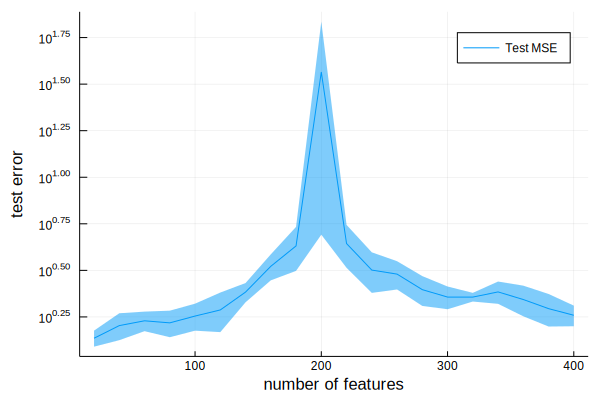

In [4]:
n = 200
ds=20:20:2n
num_informative_features = 10 # try 10, 100, 1000
nreps = 10

mses = zeros(length(ds),nreps)
train_errors = zeros(length(ds),nreps)
@time for rep in 1:nreps
    mse = []
    train_error = []
    for d in ds
        Xtrain,ytrain = random_features(n,d; num_informative_features=num_informative_features)
        w = Xtrain\ytrain
        Xtest,ytest = random_features(Int(n/10),d; num_informative_features=num_informative_features)
        push!(mse, norm(ytest-Xtest*w))
        push!(train_error, norm(ytrain-Xtrain*w))
    end
    mses[:,rep] = mse
    train_errors[:,rep] = train_error
end
mean_mse = mean(mses,dims=2)
std_mse = std(mses,dims=2)
mean_te = mean(train_errors,dims=2)
std_te = std(train_errors,dims=2)

std_mse = min.(std_mse,.9mean_mse) # a hack to ensure we don't try to plot a negative number on a log plot
std_te = min.(std_te,.9mean_te) # a hack to ensure we don't try to plot a negative number on a log plot
plot(ds,mean_mse,ribbon=std_mse,label="Test MSE")
# plot!(ds,mean_te,ribbon=std_te,label="Train MSE")
yaxis!(:log)
ylabel!("test error")
xlabel!("number of features")

## Observations: 

1. The error blows up as $d \to n$.
2. With 10 informative features, the best test error occurs for d as small as possible.
3. With 100 informative features, the best test error occurs around d=100.
4. When all features are informative, the best test error occurs as $d \to \infty$ (or, at least, as large as we tested).

# MNIST

In [6]:
# read data 
using MLDatasets, ImageCore

Xtrain, ytrain = MNIST.traindata()
Xtest,  ytest  = MNIST.testdata()

Xtrain = MNIST.convert2features(Xtrain)'
Xtest = MNIST.convert2features(Xtest)'

10000×784 Adjoint{Normed{UInt8,8},Base.ReshapedArray{Normed{UInt8,8},2,Base.ReinterpretArray{Normed{UInt8,8},3,UInt8,Array{UInt8,3}},Tuple{}}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [7]:
# view training data as images; eg the 5th example:
MNIST.convert2image(MNIST.traintensor(5))

In [8]:
ReLU(x) = max(x,0)

struct RandomFeatureMap
    W::AbstractArray
end
RandomFeatureMap(din,dout) = RandomFeatureMap(randn(din,dout))

function featurize(X,M::RandomFeatureMap)
    return ReLU.(X*M.W)
end

featurize (generic function with 1 method)

In [9]:
ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=100:100:800
nreps = 2

mses = zeros(length(ds),nreps)
@time for rep in 1:nreps
    mse = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        push!(mse, norm(ytest_samp-phiXtest*w))
    end
    mses[:,rep] = mse
end
mean_mse = mean(mses,dims=2)
std_mse = std(mses,dims=2);

100
200
300
400
500
600
700
800
100
200
300
400
500
600
700
800
 40.026388 seconds (1.71 M allocations: 305.346 MiB, 0.54% gc time)
